## Imports ##

In [1]:
import os
import pickle
import json
import joblib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne
# from mne import events_from_annotations, concatenate_raws

from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline
from scipy.integrate import simps
from sklearn.metrics import r2_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,Matern,RationalQuadratic,ExpSineSquared

from sklearn.metrics import classification_report, accuracy_score

from processing.Processing_EEG import process_eeg_raw, process_eeg_epochs
from processing.Processing_NIRS import process_nirs_raw, process_nirs_epochs

from utilities.Read_Data import read_subject_raw_nirs, read_subject_raw_eeg
from utilities.utilities import translate_channel_name_to_ch_id, find_sections, spatial_zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F



## Constants ##

In [2]:
BASE_PATH = '/Users/mm/dev/super_resolution/eeg_fNIRs/shin_2017/data/'

ROOT_DIRECTORY_EEG = os.path.join(BASE_PATH, 'raw/eeg/')
ROOT_DIRECTORY_NIRS = os.path.join(BASE_PATH, 'raw/nirs/')

# Trial order
TRIAL_TO_CHECK_NIRS = {'VP001': {
                            'nback': ['2016-05-26_007', '2016-05-26_008', '2016-05-26_009',],
                            'gonogo': ['2016-05-26_001', '2016-05-26_002', '2016-05-26_003',],
                            'word': ['2016-05-26_004', '2016-05-26_005', '2016-05-26_006',]
                        },
                        'VP002': {
                            'nback': ['2016-05-26_016', '2016-05-26_017', '2016-05-26_018',],
                            'gonogo': ['2016-05-26_010', '2016-05-26_011', '2016-05-26_012',],
                            'word': ['2016-05-26_013', '2016-05-26_014', '2016-05-26_015',]
                        },
                        'VP003': {
                            'nback': ['2016-05-27_001', '2016-05-27_002', '2016-05-27_003',],
                            'gonogo': ['2016-05-27_007', '2016-05-27_008', '2016-05-27_009',],
                            'word': ['2016-05-27_004', '2016-05-27_005', '2016-05-27_006',]
                        },
                        'VP004': {
                            'nback': ['2016-05-30_001', '2016-05-30_002', '2016-05-30_003'],
                            'gonogo': ['2016-05-30_007', '2016-05-30_008', '2016-05-30_009'],
                            'word': ['2016-05-30_004', '2016-05-30_005', '2016-05-30_006']
                        },
                        'VP005': {
                            'nback': ['2016-05-30_010', '2016-05-30_011', '2016-05-30_012'],
                            'gonogo': ['2016-05-30_016', '2016-05-30_017', '2016-05-30_018'],
                            'word': ['2016-05-30_013', '2016-05-30_014', '2016-05-30_015']
                        },
                        'VP006': {
                            'nback': ['2016-05-31_001', '2016-05-31_002', '2016-05-31_003'],
                            'gonogo': ['2016-05-31_007', '2016-05-31_008', '2016-05-31_009'],
                            'word': ['2016-05-31_004', '2016-05-31_005', '2016-05-31_006']
                        },
                        'VP007': {
                            'nback': ['2016-06-01_001', '2016-06-01_002', '2016-06-01_003'],
                            'gonogo': ['2016-06-01_007', '2016-06-01_008', '2016-06-01_009'],
                            'word': ['2016-06-01_004', '2016-06-01_005', '2016-06-01_006']
                        },
                        'VP008': {
                            'nback': ['2016-06-02_001', '2016-06-02_002', '2016-06-02_003'],
                            'gonogo': ['2016-06-02_007', '2016-06-02_008', '2016-06-02_009'],
                            'word': ['2016-06-02_004', '2016-06-02_005', '2016-06-02_006']
                        },
                        'VP009': {
                            'nback': ['2016-06-02_010', '2016-06-02_011', '2016-06-02_012'],
                            'gonogo': ['2016-06-02_016', '2016-06-02_017', '2016-06-02_018'],
                            'word': ['2016-06-02_013', '2016-06-02_014', '2016-06-02_015']
                        },
                        'VP010': {
                            'nback': ['2016-06-03_001', '2016-06-03_002', '2016-06-03_003'],
                            'gonogo': ['2016-06-03_007', '2016-06-03_008', '2016-06-03_009'],
                            'word': ['2016-06-03_004', '2016-06-03_005', '2016-06-03_006']
                        },
                        'VP011': {
                            'nback': ['2016-06-03_010', '2016-06-03_011', '2016-06-03_012'],
                            'gonogo': ['2016-06-03_016', '2016-06-03_017', '2016-06-03_018'],
                            'word': ['2016-06-03_013', '2016-06-03_014', '2016-06-03_015']
                        },'VP012': {
                            'nback': ['2016-06-06_001', '2016-06-06_002', '2016-06-06_003'],
                            'gonogo': ['2016-06-06_007', '2016-06-06_008', '2016-06-06_009'],
                            'word': ['2016-06-06_004', '2016-06-06_005', '2016-06-06_006']
                        },'VP013': {
                            'nback': ['2016-06-06_010', '2016-06-06_011', '2016-06-06_012'],
                            'gonogo': ['2016-06-06_016', '2016-06-06_017', '2016-06-06_018'],
                            'word': ['2016-06-06_013', '2016-06-06_014', '2016-06-06_015']
                        },'VP014': {
                            'nback': ['2016-06-07_001', '2016-06-07_002', '2016-06-07_003'],
                            'gonogo': ['2016-06-07_007', '2016-06-07_008', '2016-06-07_009'],
                            'word': ['2016-06-07_004', '2016-06-07_005', '2016-06-07_006']
                        },'VP015': {
                            'nback': ['2016-06-07_010', '2016-06-07_011', '2016-06-07_012'],
                            'gonogo': ['2016-06-07_016', '2016-06-07_017', '2016-06-07_018'],
                            'word': ['2016-06-07_013', '2016-06-07_014', '2016-06-07_015']
                        },'VP016': {
                            'nback': ['2016-06-08_001', '2016-06-08_002', '2016-06-08_003'],
                            'gonogo': ['2016-06-08_007', '2016-06-08_008', '2016-06-08_009'],
                            'word': ['2016-06-08_004', '2016-06-08_005', '2016-06-08_006']
                        },'VP017': {
                            'nback': ['2016-06-09_001', '2016-06-09_002', '2016-06-09_003'],
                            'gonogo': ['2016-06-09_007', '2016-06-09_008', '2016-06-09_009'],
                            'word': ['2016-06-09_004', '2016-06-09_005', '2016-06-09_006']
                        },'VP018': {
                            'nback': ['2016-06-10_001', '2016-06-10_002', '2016-06-10_003'],
                            'gonogo': ['2016-06-10_007', '2016-06-10_008', '2016-06-10_009'],
                            'word': ['2016-06-10_004', '2016-06-10_005', '2016-06-10_006']
                        },'VP019': {
                            'nback': ['2016-06-13_001', '2016-06-13_002', '2016-06-13_003'],
                            'gonogo': ['2016-06-13_007', '2016-06-13_008', '2016-06-13_009'],
                            'word': ['2016-06-13_004', '2016-06-13_005', '2016-06-13_006']
                        },'VP020': {
                            'nback': ['2016-06-14_001', '2016-06-14_002', '2016-06-14_003'],
                            'gonogo': ['2016-06-14_007', '2016-06-14_008', '2016-06-14_009'],
                            'word': ['2016-06-14_004', '2016-06-14_005', '2016-06-14_006']
                        },'VP021': {
                            'nback': ['2016-06-14_010', '2016-06-14_011', '2016-06-14_012'],
                            'gonogo': ['2016-06-14_016', '2016-06-14_017', '2016-06-14_018'],
                            'word': ['2016-06-14_013', '2016-06-14_014', '2016-06-14_015']
                        },'VP022': {
                            'nback': ['2016-06-15_001', '2016-06-15_002', '2016-06-15_003'],
                            'gonogo': ['2016-06-15_007', '2016-06-15_008', '2016-06-15_009'],
                            'word': ['2016-06-15_004', '2016-06-15_005', '2016-06-15_006']
                        },'VP023': {
                            'nback': ['2016-06-16_001', '2016-06-16_002', '2016-06-16_003'],
                            'gonogo': ['2016-06-16_007', '2016-06-16_008', '2016-06-16_009'],
                            'word': ['2016-06-16_004', '2016-06-16_005', '2016-06-16_006']
                        },'VP024': {
                            'nback': ['2016-06-16_010', '2016-06-16_011', '2016-06-16_012'],
                            'gonogo': ['2016-06-16_016', '2016-06-16_017', '2016-06-16_018'],
                            'word': ['2016-06-16_013', '2016-06-16_014', '2016-06-16_015']
                        },
                        'VP025': {
                            'nback': ['2016-06-17_010', '2016-06-17_011', '2016-06-17_012',],
                            'gonogo': ['2016-06-17_016', '2016-06-17_017', '2016-06-17_018',],
                            'word': ['2016-06-17_013', '2016-06-17_014', '2016-06-17_015',]
                        },
                        'VP026': {
                            'nback': ['2016-07-11_001', '2016-07-11_002', '2016-07-11_003',],
                            'gonogo': ['2016-07-11_007', '2016-07-11_008', '2016-07-11_009',],
                            'word': ['2016-07-11_004', '2016-07-11_005', '2016-07-11_006',]
                        }
                    }

# Task translation dictionaries
EEG_EVENT_TRANSLATIONS = {
            'nback': {
                'Stimulus/S 16': '0-back target',
                'Stimulus/S 48': '2-back target',
                'Stimulus/S 64': '2-back non-target',
                'Stimulus/S 80': '3-back target',
                'Stimulus/S 96': '3-back non-target',
                'Stimulus/S112': '0-back session',
                'Stimulus/S128': '2-back session',
                'Stimulus/S144': '3-back session'},
            'gonogo': {
                'Stimulus/S 16': 'go',
                'Stimulus/S 32': 'nogo',
                'Stimulus/S 48': 'gonogo session'},
            'word': {
                'Stimulus/S 16': 'verbal_fluency',
                'Stimulus/S 32': 'baseline'}
}
NIRS_EVENT_TRANSLATIONS = {
    'nback': {
        '7.0': '0-back session',
        '8.0': '2-back session',
        '9.0': '3-back session'},
    'gonogo': {
        '3.0': 'gonogo session'},
    'word': {
        '1.0': 'verbal_fluency',
        '2.0': 'baseline'}
}

# Sub tasks to crop times to for same length
TASK_STIMULOUS_TO_CROP = {'nback': ['0-back session', '2-back session', '3-back session'],
                            'gonogo': ['gonogo session'],
                            'word': ['verbal_fluency', 'baseline']
                            }

# EEG Coordinates
EEG_COORDS = {'FP1':(-0.3090,0.9511,0.0001), #Fp1
                'AFF5':(-0.5417,0.7777,0.3163), #AFF5h
                'AFz':(0.0000,0.9230,0.3824),
                'F1':(-0.2888,0.6979,0.6542),
                'FC5':(-0.8709,0.3373,0.3549),
                'FC1':(-0.3581,0.3770,0.8532),
                'T7':(-1.0000,0.0000,0.0000),
                'C3':(-0.7066,0.0001,0.7066),
                'Cz':(0.0000,0.0002,1.0000),
                'CP5':(-0.8712,-0.3372,0.3552),
                'CP1':(-0.3580,-0.3767,0.8534),
                'P7':(-0.8090,-0.5878,-0.0001),
                'P3':(-0.5401,-0.6724,0.5045),
                'Pz':(0.0000,-0.7063,0.7065),
                'POz':(0.0000,-0.9230,0.3824),
                'O1':(-0.3090,-0.9511,0.0000),
                'FP2':(0.3091,0.9511,0.0000), #Fp2
                'AFF6':(0.5417,0.7777,0.3163), #AFF6h
                'F2':(0.2888,0.6979,0.6542),
                'FC2':(0.3581,0.3770,0.8532),
                'FC6':(0.8709,0.3373,0.3549),
                'C4':(0.7066,0.0001,0.7066),
                'T8':(1.0000,0.0000,0.0000),
                'CP2':(0.3580,-0.3767,0.8534),
                'CP6':(0.8712,-0.3372,0.3552),
                'P4':(0.5401,-0.6724,0.5045),
                'P8':(0.8090,-0.5878,-0.0001),
                'O2':(0.3090,-0.9511,0.0000),
                'TP9':(-0.8777,-0.2852,-0.3826),
                'TP10':(0.8777,-0.2853,-0.3826),
                
                'Fp1':(-0.3090,0.9511,0.0001),
                'AFF5h':(-0.5417,0.7777,0.3163),
                'Fp2':(0.3091,0.9511,0.0000),
                'AFF6h':(0.5417,0.7777,0.3163),}

# NIRS Ccoordinates
NIRS_COORDS = {
    'AF7':(-0.5878,0.809,0),
    'AFF5':(-0.6149,0.7564,0.2206),
    'AFp7':(-0.454,0.891,0),
    'AF5h':(-0.4284,0.875,0.2213),
    'AFp3':(-0.2508,0.9565,0.1438),
    'AFF3h':(-0.352,0.8111,0.4658),
    'AF1':(-0.1857,0.915,0.3558),
    'AFFz':(0,0.8312,0.5554),
    'AFpz':(0,0.9799,0.1949),
    'AF2':(0.1857,0.915,0.3558),
    'AFp4':(0.2508,0.9565,0.1437),
    'FCC3':(-0.6957,0.1838,0.6933),
    'C3h':(-0.555,0.0002,0.8306),
    'C5h':(-0.8311,0.0001,0.5552),
    'CCP3':(-0.6959,-0.1836,0.6936),
    'CPP3':(-0.6109,-0.5259,0.5904),
    'P3h':(-0.4217,-0.6869,0.5912),
    'P5h':(-0.6411,-0.6546,0.3985),
    'PPO3':(-0.4537,-0.796,0.3995),
    'AFF4h':(0.352,0.8111,0.4658),
    'AF6h':(0.4284,0.875,0.2212),
    'AFF6':(0.6149,0.7564,0.2206),
    'AFp8':(0.454,0.891,0),
    'AF8':(0.5878,0.809,0),
    'FCC4':(0.6957,0.1838,0.6933),
    'C6h':(0.8311,0.0001,0.5552),
    'C4h':(0.555,0.0002,0.8306),
    'CCP4':(0.6959,-0.1836,0.6936),
    'CPP4':(0.6109,-0.5258,0.5904),
    'P6h':(0.6411,-0.6546,0.3985),
    'P4h':(0.4216,-0.687,0.5912),
    'PPO4':(0.4537,-0.796,0.3995),
    'PPOz':(0,-0.8306,0.5551),
    'PO1':(-0.1858,-0.9151,0.3559),
    'PO2':(0.1859,-0.9151,0.3559),
    'POOz':(0,-0.9797,0.1949)}

# EEG Channels names
EEG_CHANNEL_NAMES = ['FP1', 
                    'AFF5h', 
                    'AFz', 
                    'F1', 
                    'FC5', 
                    'FC1', 
                    'T7', 
                    'C3', 
                    'Cz', 
                    'CP5', 
                    'CP1', 
                    'P7', 
                    'P3', 
                    'Pz', 
                    'POz', 
                    'O1',  
                    'FP2', 
                    'AFF6h',
                    'F2', 
                    'FC2', 
                    'FC6', 
                    'C4', 
                    'T8', 
                    'CP2', 
                    'CP6', 
                    'P4', 
                    'P8', 
                    'O2',
                    'HEOG',
                    'VEOG']

## Parameters - Raw ##

In [3]:
## Subject/Trial Parameters ##
subject_ids = np.arange(1,2) # 1-27
subjects = []
for i in subject_ids:
    subjects.append(f'VP{i:03d}')

tasks = ['nback','gonogo','word']

# NIRS Sampling rate
fnirs_sample_rate = 10
# EEG Downsampling rate
eeg_sample_rate = 10

# Do processing or not
do_processing = True

# Redo preprocessing pickle files, TAKES A LONG TIME 
redo_preprocessing = False

# Redo data formating pickle files, TAKES A LONG TIME
redo_data_formatting = False

## Signal Prediction ##

### Parameters - Signal Prediction

In [4]:
# Time window (seconds)
eeg_t_min = -10
eeg_t_max = 10
nirs_t_min = -10
nirs_t_max = 10

offset_t = 0

# Train/Test Size
train_size = 4000
test_size = 500

# training loop
n_epochs = 100

# Define channels to use
nirs_channels_to_use_base = list(NIRS_COORDS.keys())
use_hbr = False
# nirs_channels_to_use_base = ['AF7','AFF5', 'AFp5h','AFp3','C6h','C4h','CCP4','CPP4']
eeg_channels_to_use = EEG_CHANNEL_NAMES
# eeg_channels_to_use = ['Cz', 'P7']

### Extract Data ###

In [5]:
from scipy.io import loadmat

matlab_eeg = loadmat(os.path.join(BASE_PATH, 'eeg_data_vp004.mat'))
matlab_nirs = loadmat(os.path.join(BASE_PATH, 'oxy_data_vp004.mat'))

eeg_data = matlab_eeg['eeg_block'][0][0].T
nirs_data = matlab_nirs['fnirs_oxy_block_upsampled'][0][0].T

full eeg size: (30, 109453)
full nirs size: (36, 109453)
(36, 98508)
(30, 98508)
(5000, 4000, 36)
(5000, 4000, 30)


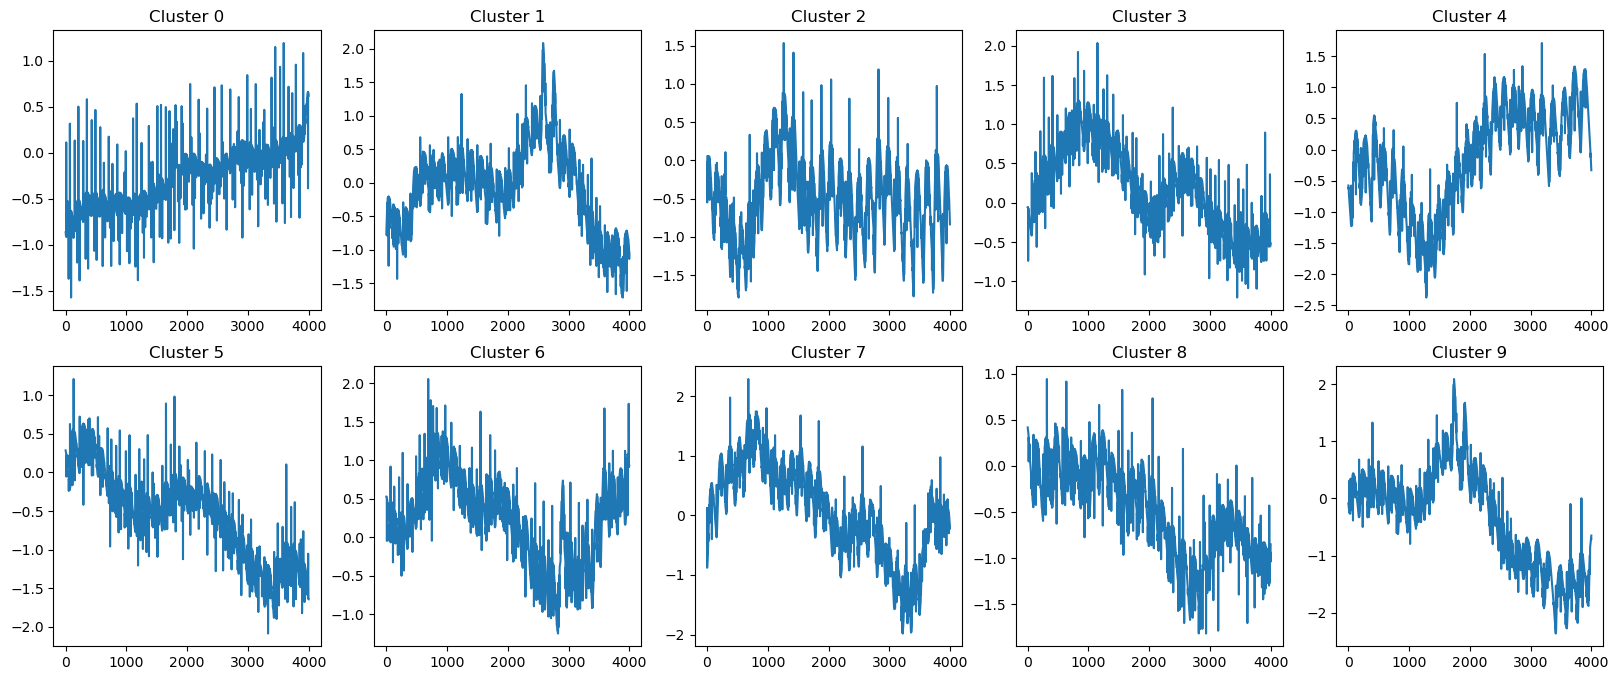

In [16]:
def grab_random_windows(nirs_data, 
                        eeg_data,
                        sampling_rate,
                        nirs_t_min, 
                        nirs_t_max,
                        eeg_t_min, 
                        eeg_t_max,
                        number_of_windows=1000):
    '''make number_of_windows of size t_min to t_max for each offset 0 to offset_t for eeg and nirs'''

    print(nirs_data.shape)
    print(eeg_data.shape)

    nirs_i_min = int(nirs_t_min*sampling_rate)
    nirs_i_max = int(nirs_t_max*sampling_rate)
    eeg_i_min = int(eeg_t_min*sampling_rate)
    eeg_i_max = int(eeg_t_max*sampling_rate)

    max_center_eeg = eeg_data.shape[1] - eeg_i_max
    max_center_nirs = nirs_data.shape[1] - nirs_i_max
    max_center = np.min([max_center_eeg, max_center_nirs])

    min_center_eeg = np.abs(eeg_i_min)
    min_center_nirs = np.abs(nirs_i_min)
    min_center = np.max([min_center_eeg, min_center_nirs])

    nirs_full_windows = []
    eeg_full_windows = []
    meta_data = []
    for i in range(number_of_windows):
        center_point = np.random.randint(min_center, max_center)
        meta_data.append(center_point)
        
        # EEG
        eeg_low_index = center_point + eeg_i_min
        eeg_high_index = center_point + eeg_i_max
        eeg_full_windows.append(eeg_data[:,eeg_low_index:eeg_high_index])

        # Nirs
        nirs_low_index = center_point + nirs_i_min
        nirs_high_index = center_point + nirs_i_max
        nirs_full_windows.append(nirs_data[:,nirs_low_index:nirs_high_index])
    
    nirs_full_windows = np.array(nirs_full_windows)
    eeg_full_windows = np.array(eeg_full_windows)

    return eeg_full_windows, nirs_full_windows, meta_data

print(f'full eeg size: {eeg_data.shape}')
print(f'full nirs size: {nirs_data.shape}')

# split data nirs and eeg into test train 
test = int(eeg_data.shape[1]*0.1)
eeg_train = eeg_data[:,:-test]
nirs_train = nirs_data[:,:-test]
eeg_test = eeg_data[:,-test:]
nirs_test = nirs_data[:,-test:]


eeg_windowed_train, nirs_windowed_train, meta_data = grab_random_windows(
             nirs_data=nirs_train, 
             eeg_data=eeg_train,
             sampling_rate=200,
             nirs_t_min=nirs_t_min, 
             nirs_t_max=nirs_t_max,
             eeg_t_min=eeg_t_min, 
             eeg_t_max=eeg_t_max,
             number_of_windows=5000)

eeg_windowed_train = eeg_windowed_train.transpose(0,2,1)
nirs_windowed_train = nirs_windowed_train.transpose(0,2,1)
print(nirs_windowed_train.shape)
print(eeg_windowed_train.shape)
# plot 10 subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    axs[i//5, i%5].plot(nirs_windowed_train[i,:,0])
    axs[i//5, i%5].set_title(f'Cluster {i}')
plt.show()

### CCA Projection

In [9]:
from timeseries_clustering_vae.vrae.vrae import VRAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

eeg_train_tensor = torch.from_numpy(eeg_windowed_train[:,:,:2]).float()
meta_data_tensor = torch.from_numpy(np.array(meta_data)).float()

print(eeg_train_tensor.shape)

hidden_size = 90
hidden_layer_depth = 1
latent_length = 10
batch_size = 10
learning_rate = 0.0005
n_epochs = 10
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

sequence_length = eeg_train_tensor.shape[1]
number_of_features = eeg_train_tensor.shape[2]
print(sequence_length)
print(number_of_features)

nirs_vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block)


eeg_train_dataset = TensorDataset(eeg_train_tensor, eeg_train_tensor, meta_data_tensor)
nirs_vrae.fit(eeg_train_dataset)



torch.Size([5000, 200, 2])
200
2
Epoch: 0
Batch 30, loss = 5250.2324, recon_loss = 5250.2100, kl_loss = 0.0227
Batch 60, loss = 6845.8618, recon_loss = 6843.9297, kl_loss = 1.9322
Batch 90, loss = 3819.0142, recon_loss = 3817.9548, kl_loss = 1.0594
Batch 120, loss = 3301.3716, recon_loss = 3298.0369, kl_loss = 3.3347
Batch 150, loss = 2897.8743, recon_loss = 2894.7161, kl_loss = 3.1582
Batch 180, loss = 2562.0574, recon_loss = 2560.2896, kl_loss = 1.7678
Batch 210, loss = 3991.0359, recon_loss = 3988.9336, kl_loss = 2.1023
Batch 240, loss = 3182.0369, recon_loss = 3179.7769, kl_loss = 2.2601
Batch 270, loss = 2572.2251, recon_loss = 2571.0884, kl_loss = 1.1367
Batch 300, loss = 3309.1973, recon_loss = 3307.5444, kl_loss = 1.6529
Batch 330, loss = 3236.7854, recon_loss = 3235.0044, kl_loss = 1.7811
Batch 360, loss = 2859.8071, recon_loss = 2858.5017, kl_loss = 1.3054
Batch 390, loss = 4673.3184, recon_loss = 4672.2183, kl_loss = 1.1001
Batch 420, loss = 2629.7510, recon_loss = 2628.7966

In [10]:
import torch
from torch import nn
import torch.nn.functional as F

class VRNN(nn.Module):
    def __init__(self, eeg_channels, fnirs_channels, hidden_dim, latent_dim):
        super(VRNN, self).__init__()
        # Encoders
        self.eeg_encoder = nn.GRU(eeg_channels, hidden_dim, batch_first=True)
        self.fnirs_encoder = nn.GRU(fnirs_channels, hidden_dim, batch_first=True)
        
        # Variational layers for EEG
        self.eeg_mu = nn.Linear(hidden_dim, latent_dim)
        self.eeg_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Variational layers for fNIRS
        self.fnirs_mu = nn.Linear(hidden_dim, latent_dim)
        self.fnirs_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.GRU(latent_dim, hidden_dim, batch_first=True)
        self.reconstruction = nn.Linear(hidden_dim, eeg_channels)

    def forward(self, x_fnirs, y_eeg):
        # Encode fNIRS
        _, h_fnirs = self.fnirs_encoder(x_fnirs)
        fnirs_mu = self.fnirs_mu(h_fnirs[-1])
        fnirs_logvar = self.fnirs_logvar(h_fnirs[-1])
        z_fnirs = self.reparameterize(fnirs_mu, fnirs_logvar)
        
        # Encode EEG
        _, h_eeg = self.eeg_encoder(y_eeg)
        eeg_mu = self.eeg_mu(h_eeg[-1])
        eeg_logvar = self.eeg_logvar(h_eeg[-1])
        z_eeg = self.reparameterize(eeg_mu, eeg_logvar)
        
        # Decode (reconstruct EEG)
        z_eeg = z_eeg.unsqueeze(1).repeat(1, y_eeg.size(1), 1)  # Repeat latent vector across sequence
        output, _ = self.decoder(z_eeg)
        recon_y = self.reconstruction(output)
        
        return recon_y, eeg_mu, eeg_logvar, fnirs_mu, fnirs_logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

In [13]:
from torch.optim import Adam
import torch.nn.functional as F

def train(model, optimizer, data_loader, epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0
        for x_fnirs, y_eeg in data_loader:  # data_loader should yield batches of (fNIRS, EEG) data
            optimizer.zero_grad()  # Clear gradients

            # Forward pass
            recon_y, eeg_mu, eeg_logvar, fnirs_mu, fnirs_logvar = model(x_fnirs, y_eeg)

            # Calculate losses
            reconstruction_loss = F.mse_loss(recon_y, y_eeg)
            kl_loss_eeg = -0.5 * torch.sum(1 + eeg_logvar - eeg_mu.pow(2) - eeg_logvar.exp())
            kl_loss_fnirs = -0.5 * torch.sum(1 + fnirs_logvar - fnirs_mu.pow(2) - fnirs_logvar.exp())
            kl_loss = kl_loss_eeg + kl_loss_fnirs

            # Normalize by number of elements for stability
            kl_loss /= (eeg_mu.size(0) * eeg_mu.size(1))
            loss = reconstruction_loss + kl_loss  # Total loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(data_loader)}")

nirs_train_tensor = torch.from_numpy(nirs_windowed_train[:,:,:10]).float()
eeg_train_tensor = torch.from_numpy(eeg_windowed_train[:,:,:1]).float()
meta_data_tensor = torch.from_numpy(np.array(meta_data)).float()

print(nirs_train_tensor.shape)
print(eeg_train_tensor.shape)

sequence_length = eeg_train_tensor.shape[1]
eeg_number_of_features = eeg_train_tensor.shape[2]
nirs_number_of_features = nirs_train_tensor.shape[2]

eeg_train_dataset = TensorDataset(nirs_train_tensor, eeg_train_tensor)

# Parameters Initialization
model = VRNN(eeg_channels=eeg_number_of_features, fnirs_channels=nirs_number_of_features, hidden_dim=128, latent_dim=64)
optimizer = Adam(model.parameters(), lr=0.001)

train(model, optimizer, eeg_train_dataset, epochs=10)


torch.Size([5000, 4000, 10])
torch.Size([5000, 200, 1])


RuntimeError: input.size(-1) must be equal to input_size. Expected 64, got 1

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

class EEGfNIRS_Transformer(nn.Module):
    def __init__(self, fnirs_channels, eeg_channels, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(EEGfNIRS_Transformer, self).__init__()
        self.fnirs_channels = fnirs_channels
        self.eeg_channels = eeg_channels

        # Transformer specific params
        self.src_embed = nn.Linear(fnirs_channels, eeg_channels)
        self.pos_encoder = PositionalEncoding(eeg_channels)
        self.transformer = nn.Transformer(d_model=eeg_channels, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.decoder = nn.Linear(eeg_channels, eeg_channels)

    def forward(self, src, tgt):
        src = self.src_embed(src)
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        output = self.transformer(src, tgt)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', self.encoding)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGfNIRS_Transformer(fnirs_channels=10, eeg_channels=1, nhead=1, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

nirs_train_tensor = torch.from_numpy(nirs_windowed_train[:,:,:10]).float()
eeg_train_tensor = torch.from_numpy(eeg_windowed_train[:,:,:1]).float()
meta_data_tensor = torch.from_numpy(np.array(meta_data)).float()

print(nirs_train_tensor.shape)
print(eeg_train_tensor.shape)

sequence_length = eeg_train_tensor.shape[1]
eeg_number_of_features = eeg_train_tensor.shape[2]
nirs_number_of_features = nirs_train_tensor.shape[2]

train_dataset = TensorDataset(nirs_train_tensor, eeg_train_tensor)
dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# Example training loop
for epoch in range(epochs):
    model.train()
    for src, tgt in dataloader:
        src = src.to(device)
        tgt = tgt.to(device)
        optimizer.zero_grad()
        output = model(src, tgt)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch} Loss {loss.item()}')


/Users/mm/anaconda3/envs/sr/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([5000, 4000, 10])
torch.Size([5000, 4000, 1])


KeyboardInterrupt: 

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from plotly.graph_objs import *
import plotly

from random import randint


def plot_clustering_matplotlib(z_run, labels, show=True, axes=None, title=''):

    labels = labels[:z_run.shape[0]] # because of weird batch_size

    hex_colors = []
    for _ in np.unique(labels):
        hex_colors.append('#%06X' % randint(0, 0xFFFFFF))

    colors = [hex_colors[int(i)] for i in labels]

    z_run_pca = TruncatedSVD(n_components=3).fit_transform(z_run)
    z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run)

    if axes is None or len(axes) < 2:
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].scatter(z_run_pca[:, 0], z_run_pca[:, 1], c=colors, marker='*', linewidths=0)
    axes[0].set_title(f'{title} PCA on z_run')

    axes[1].scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=colors, marker='*', linewidths=0)
    axes[1].set_title(f'{title} TSNE on z_run')
    if show:
        plt.show()
    
    return axes
    


In [ ]:
import numpy as np
from sklearn.cross_decomposition import CCA

print(eeg_windowed_train.shape)
print(nirs_windowed_train.shape)

y = eeg_windowed_train[:1000, :, 0]
x = nirs_windowed_train[:1000]
y = np.expand_dims(y, axis=2)

print(y.shape)
print(x.shape)

# Reshape the data
y_reshaped = y.reshape(y.shape[0], -1)  # Reshape to (epochs, window * EEG features)
x_reshaped = x.reshape(x.shape[0], -1)  # Reshape to (epochs, window * fNIRS features)

# Standardize the data
scaler_y = StandardScaler()
scaler_x = StandardScaler()
y_standard = scaler_y.fit_transform(y_reshaped)
x_standard = scaler_x.fit_transform(x_reshaped)

# Define the number of components
cca = CCA(n_components=50)

# Fit and transform the data
y_c, x_c = cca.fit_transform(y_standard, x_standard)

print(y_c.shape)
print(x_c.shape)

# y_c and x_c are the projections of the original EEG and fNIRS data into the shared latent space

(5000, 200, 30)
(5000, 4000, 36)
(1000, 200, 1)
(1000, 4000, 36)
(1000, 50)
(1000, 50)


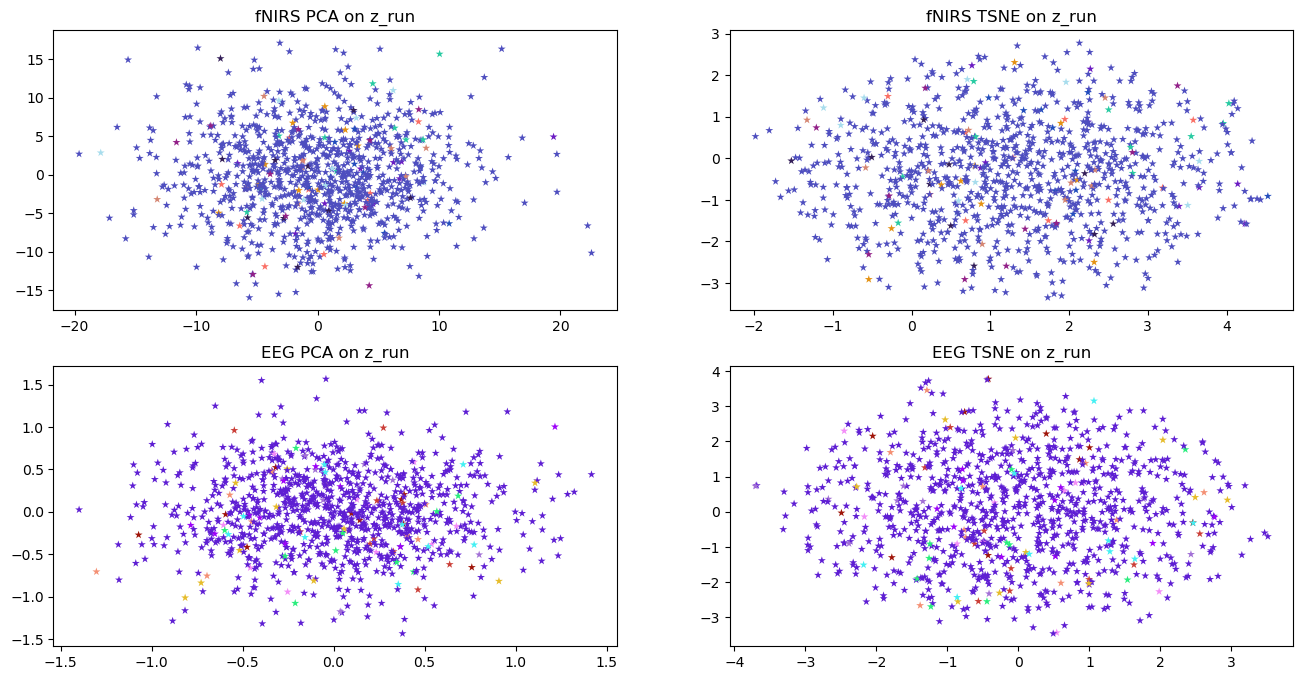

In [ ]:
label = 0
fake_labels = np.zeros((x_c.shape[0]), dtype=int)
for i in range(0, x_c.shape[0], 100):
    for j in range(10):
        fake_labels[i+j] = label
    label += 1

# plot x and y latents side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
plot_clustering_matplotlib(x_c, fake_labels, show=False, axes=axes[0], title='fNIRS')
plot_clustering_matplotlib(y_c, fake_labels, show=False, axes=axes[1], title='EEG')
plt.show()

In [ ]:
fake_labels = [0] * eeg_latents.shape[0]
plot_clustering(eeg_latents, fake_labels, engine='matplotlib', download = False)

In [ ]:
fake_labels = [0] * nirs_latents.shape[0]
plot_clustering(nirs_latents, fake_labels, engine='matplotlib', download = False)

In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, sequence_length, number_of_features, hidden_dim, output_steps, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=number_of_features, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_steps)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions

def train_nirs_to_eeg_lstm(model, train_loader, num_epochs=10):
    model.train()

    # loss_fn = torch.nn.MSELoss()
    # loss_fn = CCALoss()
    # loss_fn = CorrelationLoss()
    loss_function = nn.MSELoss()
    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (nirs_data, eeg_data) in enumerate(train_loader):  # Assume loader gives EEG and corresponding fNIRS data
            optimizer.zero_grad()

            # Forward pass
            predictions = model(nirs_data)
            
            # Compute loss
            loss = loss_function(predictions, eeg_data)
            
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * nirs_data.shape[0]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / nirs_data.shape[0]:.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return model

print(nirs_x_train.shape)
print(eeg_x_train.shape)
lstm_dataset = TensorDataset(nirs_x_train, eeg_x_train)
    
number_of_features = nirs_x_test.shape[2]
sequence_length = nirs_x_test.shape[1]
output_steps = eeg_x_train.shape[1]
hidden_dim = 128  # Number of LSTM units
batch_size = 500

model = LSTMModel(sequence_length=sequence_length, number_of_features=number_of_features, hidden_dim=hidden_dim, output_steps=output_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

dataloader = DataLoader(lstm_dataset, batch_size=batch_size, shuffle=True)

loss_function = nn.MSELoss()

lstm_model = train_nirs_to_eeg_lstm(model, dataloader, num_epochs=3)

In [ ]:
def predict_eeg_from_nirs_lstm(model, nirs_data):
    model.eval()
    with torch.no_grad():
        predicted_eeg = model(nirs_data)
    return predicted_eeg.numpy()

nirs_test_data = nirs_full_data[train_size:train_size+test_size]

eeg_test_data = full_data[train_size:train_size+test_size,0]
eeg_test_data = np.expand_dims(eeg_test_data, axis=1)

# Predict signal
nirs_x_test = torch.from_numpy(nirs_test_data).float()

nirs_predicted_eeg_lstm = predict_eeg_from_nirs_lstm(lstm_model, nirs_x_test)

epoch_to_plot = 1
size = 100

print(eeg_test_data.shape)
print(nirs_predicted_eeg_lstm.shape)

from sklearn.metrics import r2_score
r2_eeg = r2_score(eeg_test_data[epoch_to_plot:epoch_to_plot+size], nirs_predicted_eeg_lstm[epoch_to_plot:epoch_to_plot+size])
print(f'nirs r2: {r2_nirs}')

# Plot the fnirs predicted vs eeg predicted vs real EEG signal on subplots
fig, axs = plt.subplots(2)
axs[0].plot(nirs_predicted_eeg_lstm[epoch_to_plot:epoch_to_plot+size], label='Predicted EEG NIRS LSTM')
axs[0].legend()
axs[1].plot(eeg_test_data[epoch_to_plot:epoch_to_plot+size], label='Real EEG')
axs[1].legend()
plt.show()

In [ ]:
sasd=asdasdasd

### Old stuff ###

In [ ]:

asdas=dasdasdas
class NIRS_Encoder(nn.Module):
    """
    Encoder network containing enrolled LSTM/GRU

    :param number_of_features: number of input features
    :param hidden_size: hidden size of the RNN
    :param hidden_layer_depth: number of layers in RNN
    :param latent_length: latent vector length
    :param dropout: percentage of nodes to dropout
    :param block: LSTM/GRU block
    """
    def __init__(self, number_of_features, hidden_size, hidden_layer_depth, latent_length, dropout, block = 'LSTM'):

        super(NIRS_Encoder, self).__init__()

        self.number_of_features = number_of_features
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.latent_length = latent_length

        if block == 'LSTM':
            self.model = nn.LSTM(self.number_of_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)
        elif block == 'GRU':
            self.model = nn.GRU(self.number_of_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)
        else:
            raise NotImplementedError

    def forward(self, x):
        """Forward propagation of encoder. Given input, outputs the last hidden state of encoder

        :param x: input to the encoder, of shape (sequence_length, batch_size, number_of_features)
        :return: last hidden state of encoder, of shape (batch_size, hidden_size)
        """
        _, (h_end, c_end) = self.model(x)
        h_end = h_end[-1, :, :]
        return h_end


class NIRS_Lambda(nn.Module):
    """Lambda module converts output of encoder to latent vector

    :param hidden_size: hidden size of the encoder
    :param latent_length: latent vector length
    """
    def __init__(self, hidden_size, latent_length):
        super(NIRS_Lambda, self).__init__()

        self.hidden_size = hidden_size
        self.latent_length = latent_length

        self.hidden_to_mean = nn.Linear(self.hidden_size, self.latent_length)
        self.hidden_to_logvar = nn.Linear(self.hidden_size, self.latent_length)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)


        # self.bn_mean = nn.BatchNorm1d(latent_length)
        # self.bn_logvar = nn.BatchNorm1d(latent_length)

    def forward(self, cell_output):
        """Given last hidden state of encoder, passes through a linear layer, and finds the mean and variance

        :param cell_output: last hidden state of encoder
        :return: latent vector
        """

        self.latent_mean = self.hidden_to_mean(cell_output)
        self.latent_logvar = self.hidden_to_logvar(cell_output)

        # self.latent_mean = self.bn_mean(self.latent_mean)
        # self.latent_logvar = self.bn_logvar(self.latent_logvar)

        if self.training:
            std = torch.exp(0.5 * self.latent_logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(self.latent_mean)
        else:
            return self.latent_mean

class NIRS_VRAE(BaseEstimator, nn.Module):
    """Variational recurrent auto-encoder. This module is used for dimensionality reduction of timeseries

    :param sequence_length: length of the input sequence
    :param number_of_features: number of input features
    :param hidden_size:  hidden size of the RNN
    :param hidden_layer_depth: number of layers in RNN
    :param latent_length: latent vector length
    :param batch_size: number of timeseries in a single batch
    :param learning_rate: the learning rate of the module
    :param block: GRU/LSTM to be used as a basic building block
    :param n_epochs: Number of iterations/epochs
    :param dropout_rate: The probability of a node being dropped-out
    :param optimizer: ADAM/ SGD optimizer to reduce the loss function
    :param loss: SmoothL1Loss / MSELoss / ReconLoss / any custom loss which inherits from `_Loss` class
    :param boolean cuda: to be run on GPU or not
    :param print_every: The number of iterations after which loss should be printed
    :param boolean clip: Gradient clipping to overcome explosion
    :param max_grad_norm: The grad-norm to be clipped
    :param dload: Download directory where models are to be dumped
    """
    def __init__(self, sequence_length, number_of_features, hidden_size=90, hidden_layer_depth=2, latent_length=20,
                 batch_size=32, learning_rate=0.005, block='LSTM',
                 n_epochs=5, dropout_rate=0., optimizer='Adam', loss='MSELoss',
                 cuda=False, print_every=100, clip=True, max_grad_norm=5, dload='.'):

        super(NIRS_VRAE, self).__init__()


        self.dtype = torch.FloatTensor
        self.use_cuda = cuda

        if not torch.cuda.is_available() and self.use_cuda:
            self.use_cuda = False


        if self.use_cuda:
            self.dtype = torch.cuda.FloatTensor


        self.encoder = NIRS_Encoder(number_of_features = number_of_features,
                               hidden_size=hidden_size,
                               hidden_layer_depth=hidden_layer_depth,
                               latent_length=latent_length,
                               dropout=dropout_rate,
                               block=block)

        self.lmbd = NIRS_Lambda(hidden_size=hidden_size,
                           latent_length=latent_length)

        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.latent_length = latent_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.print_every = print_every
        self.clip = clip
        self.max_grad_norm = max_grad_norm
        self.is_fitted = False
        self.dload = dload

        if self.use_cuda:
            self.cuda()

        if optimizer == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        elif optimizer == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        else:
            raise ValueError('Not a recognized optimizer')

        if loss == 'SmoothL1Loss':
            self.loss_fn = nn.SmoothL1Loss(size_average=False)
        elif loss == 'MSELoss':
            self.loss_fn = nn.MSELoss(size_average=False)

    def __repr__(self):
        return """VRAE(n_epochs={n_epochs},batch_size={batch_size},cuda={cuda})""".format(
                n_epochs=self.n_epochs,
                batch_size=self.batch_size,
                cuda=self.use_cuda)

    def forward(self, x):
        """
        Forward propagation which involves one pass from inputs to encoder to lambda to decoder

        :param x:input tensor
        :return: the decoded output, latent vector
        """
        cell_output = self.encoder(x)
        latent = self.lmbd(cell_output)

        return latent, self.lmbd.latent_mean, self.lmbd.latent_logvar

    def save(self, file_name):
        """
        Pickles the model parameters to be retrieved later

        :param file_name: the filename to be saved as,`dload` serves as the download directory
        :return: None
        """
        PATH = self.dload + '/' + file_name
        if os.path.exists(self.dload):
            pass
        else:
            os.mkdir(self.dload)
        torch.save(self.state_dict(), PATH)

    def load(self, PATH):
        """
        Loads the model's parameters from the path mentioned

        :param PATH: Should contain pickle file
        :return: None
        """
        self.is_fitted = True
        self.load_state_dict(torch.load(PATH))

# Aligning the fNIRS encoder
def train_nirs_encoder(eeg_encoder, nirs_vrae, train_loader, num_epochs=10):
    nirs_vrae.train()
    eeg_encoder.eval()  # Make sure the EEG encoder does not train
    optimizer = nirs_vrae.optimizer

    # loss_fn = torch.nn.MSELoss()
    # loss_fn = CCALoss()
    loss_fn = CorrelationLoss()

    mapping_model = nn.Linear(50, 50)
    optimizer = optim.Adam(mapping_model.parameters(), lr=0.001)

    mapping_model.train()

    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (fnirs_data, eeg_data, meta_data) in enumerate(train_loader):  # Assume loader gives EEG and corresponding fNIRS data
            optimizer.zero_grad()

            # required to swap axes, since dataloader gives output in (batch_size x seq_len x num_of_features)
            fnirs_data = fnirs_data.permute(1,0,2)

            with torch.no_grad():
                eeg_latents, eeg_mu, eeg_log_var = eeg_encoder(eeg_data)
            nirs_latents, nirs_mu, nirs_log_var = nirs_vrae(fnirs_data)

            loss = loss_fn(nirs_latents, eeg_latents) + F.mse_loss(nirs_mu, eeg_mu) + F.mse_loss(nirs_log_var, eeg_log_var)
            
            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * fnirs_data.shape[1]}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / fnirs_data.shape[1]:.6f}')
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    return nirs_vrae

sequence_length = nirs_x_train.shape[1]  # Number of samples in each EEG window
number_of_features = nirs_x_train.shape[2]  # Number of channels at each time point

hidden_size = 128
hidden_layer_depth = 1
batch_size = 500
learning_rate = 0.005
n_epochs = 3
dropout_rate = 0.2
optimizer = 'Adam' # options: Adam, SGD
cuda = True # options: True, False
print_every=30
clip = False # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

# Create the model, optimizer, and loss function
nirs_vrae = NIRS_VRAE(sequence_length=sequence_length, 
                 number_of_features=number_of_features, 
                 hidden_size=hidden_size, 
                 hidden_layer_depth=hidden_layer_depth, 
                 latent_length=latent_dim,
                 batch_size=batch_size, 
                 learning_rate=learning_rate, 
                 block=block,
                 n_epochs=n_epochs, 
                 dropout_rate=dropout_rate, 
                 optimizer=optimizer, 
                 loss=loss,
                 cuda=cuda, print_every=print_every, clip=clip, max_grad_norm=max_grad_norm, dload='.')


nirs_train_loader = DataLoader(nirs_train_dataset, batch_size=batch_size, shuffle=True)

nirs_vrae = train_nirs_encoder(eeg_encoder, nirs_vrae, nirs_train_loader, num_epochs=n_epochs)


In [ ]:
crop_index = 1000

# plot entire prediction and r squared
# Flatten the data
print(nirs_predicted_eeg.shape)
print(eeg_predicted_eeg.shape)
print(eeg_test_data.shape)

full_signal_nirs_prediction = nirs_predicted_eeg.reshape(-1)[:crop_index]
full_signal_eeg_prediction = eeg_predicted_eeg.reshape(-1)[:crop_index]
full_signal_eeg = eeg_test_data.reshape(-1)[:crop_index]

print(full_signal_nirs_prediction.shape)
print(full_signal_eeg_prediction.shape)
print(full_signal_eeg.shape)

# Calculate R squared
from sklearn.metrics import r2_score
r2 = r2_score(full_signal_eeg, full_signal_nirs_prediction)
print(r2)

# plot

fig, axs = plt.subplots(3)
axs[0].plot(full_signal_nirs_prediction, label='Predicted EEG NIRS')
axs[0].legend()
axs[1].plot(full_signal_eeg_prediction, label='Predicted EEG EEG')
axs[1].legend()
axs[2].plot(full_signal_eeg, label='Real EEG')
axs[2].legend()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming `model` is your trained VAE and `data_loader` is your DataLoader for the dataset
def extract_latent_space(model, data_loader, index_for_label=0):
    model.eval()
    with torch.no_grad():
        latents = []
        labels = []  # Assuming you have some labels of interest, e.g., participant IDs
        for data, targets, meta_data in data_loader:
            mu, log_var = model.encoder(data)
            z = model.reparameterize(mu, log_var)
            latents.append(z)
            labels.append(meta_data[:, index_for_label])  # Change indexing based on what label you're interested in
        latents = torch.cat(latents).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()
    return latents, labels

def plot_latent_space(model, data_Loader, latent_name='participant'):
    if latent_name == 'participant':
        index_for_label = 0
        label_type = 'discrete'
    elif latent_name == 'temporal':
        index_for_label = 1
        label_type = 'continuous'

    latents, labels = extract_latent_space(model, data_Loader, index_for_label)

    # Applying t-SNE for dimensionality reduction to 3 components
    tsne = TSNE(n_components=3, random_state=42)
    latents_reduced = tsne.fit_transform(latents)

    # Plotting in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    if label_type == 'discrete':
        scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2],
                        c=labels, cmap='viridis', label=labels)
        legend = ax.legend(*scatter.legend_elements(), title="Participant ID")
        ax.add_artist(legend)
    elif label_type == 'continuous':
        # colorbar
        scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2],
                        c=labels, cmap='viridis', label=labels)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Temporal ID')

    ax.set_title(f't-SNE visualization of the {latent_name} Latent Space')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    plt.show()

# Plot the latent space
plot_latent_space(eeg_model, train_loader, latent_name='temporal')

In [ ]:
from timeseries_clustering_vae.vrae.vrae import VRAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
adsadsa=asdasd
# Stack participant and distance information along the second dimension
train_dataset = TensorDataset(torch.from_numpy(eeg_data_train))
print(eeg_data_train.shape)

# Assuming each EEG window is flattened into a vector
number_of_features = eeg_data_train.shape[2] # number of features in each time point
sequence_length = eeg_data_train.shape[1] #200  # Number of samples in each EEG window

hidden_size = 128
hidden_layer_depth = 3
latent_length = 50
batch_size = 32
learning_rate = 0.0005
n_epochs = 3
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU


# from timeseries_clustering_vae.vrae.utils import *
# X_train, X_val, y_train, y_val = open_data('timeseries_clustering_vae/data', ratio_train=0.9)
# train_dataset = TensorDataset(torch.from_numpy(X_train))
# print(X_train.shape)
# number_of_features = X_train.shape[2]
# sequence_length = X_train.shape[1]
# adasd=asdasd

# Create the model, optimizer, and loss function
eeg_model = VRAE(sequence_length=sequence_length, 
                 number_of_features=number_of_features, 
                 hidden_size=hidden_size, 
                 hidden_layer_depth=hidden_layer_depth, 
                 latent_length=latent_length,
                 batch_size=batch_size, 
                 learning_rate=learning_rate, 
                 block=block,
                 n_epochs=n_epochs, 
                 dropout_rate=dropout_rate, 
                 optimizer=optimizer, 
                 loss=loss,
                 cuda=cuda, print_every=print_every, clip=clip, max_grad_norm=max_grad_norm, dload='.')

eeg_model.fit(train_dataset)

eeg_encoder = eeg_model.encoder
eeg_decoder = eeg_model.decoder
